In [1]:
import numpy as np
import pandas as pd

In [45]:
data = pd.read_csv("winequality-white.csv", sep=";")
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [53]:
X = data.drop(columns="quality").values
y = data["quality"].values
y

array([6, 6, 6, ..., 6, 7, 6], dtype=int64)

In [54]:
# Transformons notre problème en de la classification binaire.
y_class = np.where(y<6,0,1)
y_class

array([1, 1, 1, ..., 1, 1, 1])

In [55]:
# Séparons nos données en un jeu d'entraînement et un jeu de test.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.3)

In [56]:
# Standardisons nos données.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [68]:
# Entraînons maintenant notre svm à noyau
from sklearn.svm import SVC
classifier = SVC(kernel = "rbf", gamma=0.01, probability = True) # le noyau est exp(- gamma * ||x-y||^2)
classifier.fit(X_train_scaled, y_train)

SVC(gamma=0.01, probability=True)

Comment se comporte notre SVM sur le jeu de test ? Pour le comprendre, observons la courbe ROC.

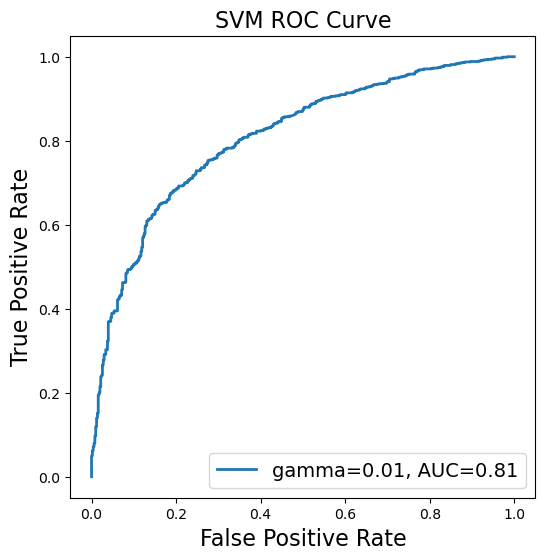

In [71]:
y_pred = classifier.predict_proba(X_test_scaled)[:, 1]

from sklearn.metrics import roc_curve, auc

False_positive_rate, True_positive_rate, threshold = roc_curve(y_test, y_pred) # On construit la courbe ROC

area = auc(False_positive_rate, True_positive_rate) # On calcule l'aire sous la courbe ROC

# créer une figure
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(6, 6))

# afficher la courbe ROC
plt.plot(False_positive_rate, True_positive_rate, '-', lw=2, label='gamma=0.01, AUC=%.2f' % area)

# donner un titre aux axes et au graphique
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('SVM ROC Curve', fontsize=16)

# afficher la légende
plt.legend(loc="lower right", fontsize=14)

# afficher l'image
plt.show()

Pour trouver les meilleurs paramètres gamma et C (C étant le poids de la régularisation L2 squared), on va faire une validation croisée. On veut maximiser roc_auc.

In [72]:
params_grid = {'C' : np.logspace(-2, 3, 6), 'gamma' : np.logspace(-2, 1, 4)}
score = 'roc_auc'

from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(SVC(kernel='rbf'),
                   params_grid,
                   cv=5, 
                   n_jobs=-1,
                   scoring=score)

grid.fit(X_train_scaled, y_train)

print("Les paramètres optimaux sont {} avec un score de {}".format(grid.best_params_, grid.best_score_))

Les paramètres optimaux sont {'C': 1.0, 'gamma': 1.0} avec un score de 0.8497508465667739


In [73]:
y_pred_cv = grid.decision_function(X_test_scaled)

In [74]:
y_pred_cv

array([ 1.02236514, -0.83409226,  0.35979164, ..., -0.53531958,
        1.15454763, -1.01459796])

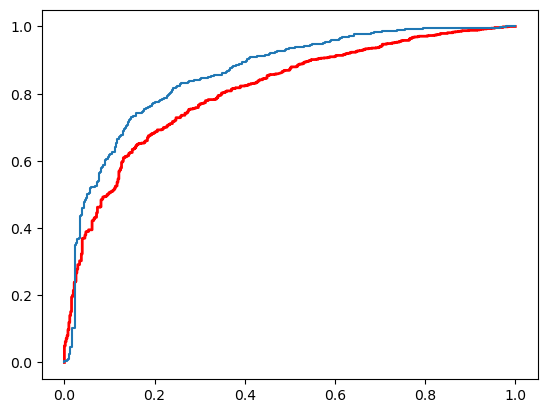

In [77]:
fpr, tpr, threshold = roc_curve(y_test, y_pred_cv)

plt.plot(False_positive_rate, True_positive_rate, '-', lw=2, color='red')
plt.plot(fpr, tpr)
plt.show()

Pour visualiser l'effet de gamma sur les données, regardons la matrice de Gram de nos données, çad la matrice des k(x_i, x_j) où x_i et x_j sont deux observations dans X.

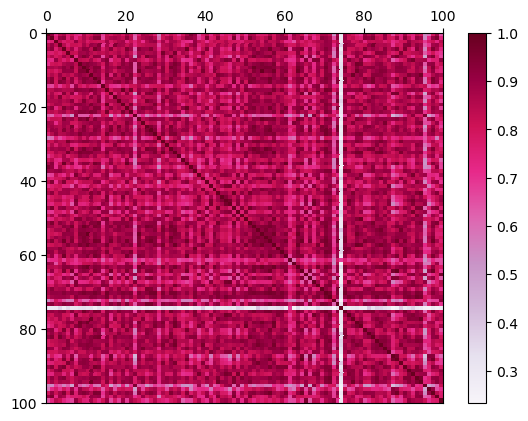

In [89]:
from sklearn.metrics.pairwise import rbf_kernel
kmatrix = rbf_kernel(X_train_scaled, gamma=0.01)

# On ne va regarder que les 100 premières lignes et colonnes de la matrice, pour en faciliter la visualiation.
kmatrix100 = kmatrix[:100, :100]

import matplotlib
plt.pcolor(kmatrix100, cmap=matplotlib.cm.PuRd)

# rajouter la légende
plt.colorbar()

# retourner l'axe des ordonnées
plt.gca().invert_yaxis()
plt.gca().xaxis.tick_top()

# afficher l'image
plt.show()